In [2]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [3]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [4]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


In [5]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [7]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 186.3678 - val_loss: 168.0045
Epoch 2/100
1875/1875 [==============================] - 10s 5ms/step - loss: 165.5256 - val_loss: 163.5553
Epoch 3/100
1875/1875 [==============================] - 10s 5ms/step - loss: 162.1771 - val_loss: 161.0779
Epoch 4/100
1875/1875 [==============================] - 10s 5ms/step - loss: 159.9537 - val_loss: 159.1648
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 158.1630 - val_loss: 157.8200
Epoch 6/100
1875/1875 [==============================] - 10s 5ms/step - loss: 156.5884 - val_loss: 155.8637
Epoch 7/100
1875/1875 [==============================] - 10s 5ms/step - loss: 155.2719 - val_loss: 154.8228
Epoch 8/100
1875/1875 [==============================] - 10s 5ms/step - loss: 154.3045 - val_loss: 154.0047
Epoch 9/100
1875/1875 [==============================] - 10s 5ms/step - loss: 153.5995 - val_loss: 153.6474
Epoch 10/100
1875/1875 [====

(10000, 2)


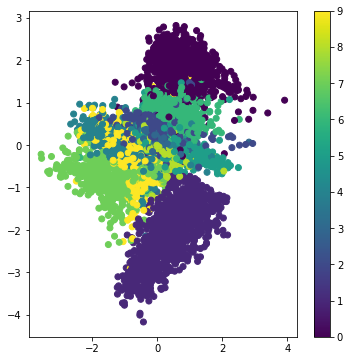

In [18]:
batch_size = 32
import matplotlib.pyplot as plt

x_test_encoded = np.array(encoder.predict(x_test, batch_size=batch_size)[0])
print(x_test_encoded.shape)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

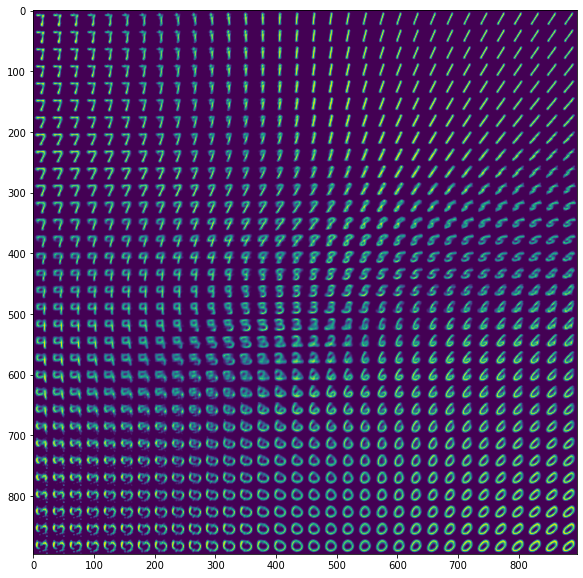

In [26]:
n = 32  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [27]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 50500       input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 784)          51152       encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_Minimum (TensorFlow [(None, 784)]        0           decoder[0][0]                    
____________________________________________________________________________________________